In [1]:
import datatable as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import data set
import pandas as pd

train = dt.fread('voterfile.csv').to_pandas()
train = train.set_index('optimus_id', drop=True)
train.rename(columns={"maritalstatus": "marital_status", 'occupationindustry': 'occupation_industry'}, inplace=True)

In [2]:
# Have a look at the first five rows
train.head()

,age,party,ethnicity,marital_status,dwellingtype,income,education,cd,dma,occupation_industry,...,intrst_musical_instruments_in_hh,donates_to_liberal_causes,donates_to_conservative_causes,home_owner_or_renter,g08_precinct_turnout,g10_precinct_turnout,g12_precinct_turnout,p08_precinct_turnout,p10_precinct_turnout,p12_precinct_turnout
optimus_id,,,,,,,,,,,,,,,,,,,,,
861681,69.0,Republican,European,Married,Single Family Dwelling Unit,75k-125k,Bach Degree - Extremely Likely,4.0,LAS VEGAS DMA (EST.),Medical,...,nan,NaN,nan,Likely Homeowner,0.56,0.54,0.75,0.17,0.32,0.24
1084850,20.0,American Independent,European,nan,nan,Unknown,nan,2.0,RENO DMA (EST.),nan,...,nan,NaN,nan,nan,0.84,0.82,0.92,0.47,0.62,0.47
644435,28.0,Non-Partisan,European,nan,nan,Unknown,nan,3.0,LAS VEGAS DMA (EST.),nan,...,nan,NaN,nan,nan,0.49,0.34,0.70,0.04,0.09,0.06
57683,78.0,American Independent,European,Married,nan,Unknown,nan,3.0,LAS VEGAS DMA (EST.),nan,...,nan,NaN,nan,nan,0.84,0.79,0.91,0.24,0.46,0.30
167371,68.0,Democratic,nan,nan,nan,Unknown,nan,4.0,LAS VEGAS DMA (EST.),nan,...,nan,NaN,nan,nan,0.71,0.66,0.81,0.19,0.37,0.34


These columns will be dropped because of the following reasons:
* dwelling_type: It's irrelevant, and income can make it up
* education: Missing data is over 40%, and "likely ..." doesn't confirm the truthfulness of it's value -> risky to use
* net_worth: High multi-colinearity with income, and also the missing values account for over 50%
* petowner_dog: It's irrelevant
* intrst_nascar_in_hh: It's irrelevant
* intrst_musical_instruments_in_hh: It's irrelevant
* home_owner_or_renter: It's irrelevant

In [3]:
train.drop(
    columns=['dwellingtype', 'education', 'net_worth', 'petowner_dog', 'intrst_nascar_in_hh',
             'intrst_musical_instruments_in_hh',
             'home_owner_or_renter'], inplace=True)

<AxesSubplot:>

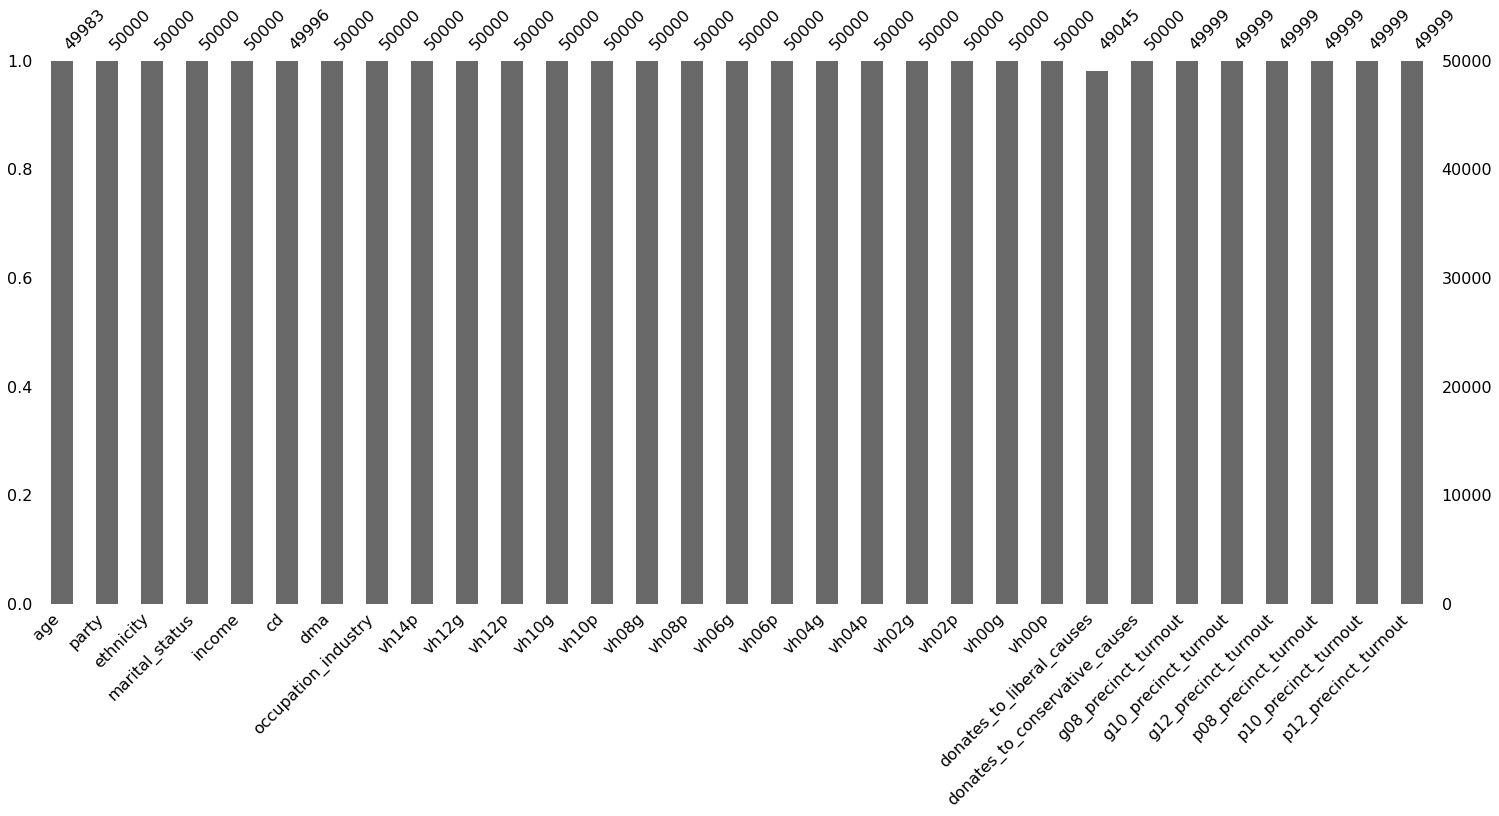

In [4]:
# Check for missing data
import missingno as msno

msno.bar(train)

Even though some columns show that there are missing data under value "nan", neither this chart nor method DataFrame.info() reflect that. Thus, I have to have a closer look at each column's values

Numeric: age

Categorical: ethnicity


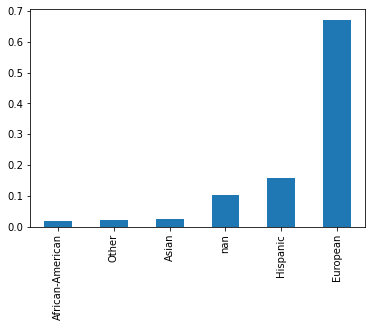


Categorical: marital_status


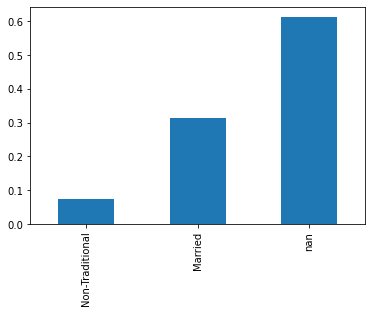


Numeric: cd

Categorical: occupation_industry


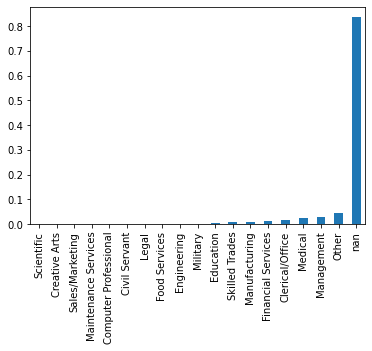


Categorical: donates_to_liberal_causes


<ipython-input-5-76e647191871>:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if train[col].isnull().sum() > 0 or 'nan' in train[col].unique():


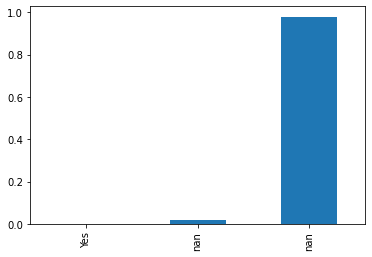


Categorical: donates_to_conservative_causes


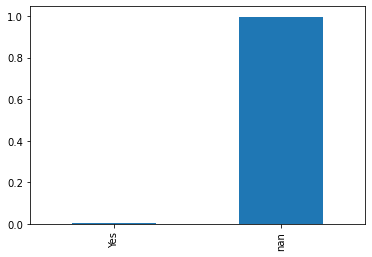


Numeric: g08_precinct_turnout

Numeric: g10_precinct_turnout

Numeric: g12_precinct_turnout

Numeric: p08_precinct_turnout

Numeric: p10_precinct_turnout

Numeric: p12_precinct_turnout



In [5]:
# Visualize non-numeric columns and their unique values
for col in train.columns:
    # If column has missing data
    if train[col].isnull().sum() > 0 or 'nan' in train[col].unique():
        # Numeric type
        if col in train.select_dtypes(np.number).columns:
            print(f'Numeric: {col}')
        # String type
        else:
            print(f'Categorical: {col}')
            train[col].value_counts(normalize=True, dropna=False).sort_values().plot(kind='bar')
            plt.show()
        print()

This is my thoughts about each column that has missing data:
* Ethnicity: Even there are “other” values in this column, “nan” still exists, which may indicate a missing-not-at-random pattern (for example, “mixed” type). Thus, nan will be converted to “Unknown” (no imputation)
* Marital status: The missing value outnumbers other values (non-traditional and married) gives me a feeling that this is also a missing-not-at-random pattern. Usually, married and single take the majority part. However, the statistics from https://statisticalatlas.com/place/Nevada/Las-Vegas/Marital-Status shows me that the gap between the two status is not that far (married even outnumbers never married). Therefore, I decide to use the same technique as ethnicity’s
* Occupation industry: As the missing account for over 80% with the existing of “other”, same technique as ethnicity’s.
* donates_to_liberal_causes, donates_to_conservative_causes: In my opinion, they did not want to reveal their political affiliation while those answered “yes” are sure about which party they would like to vote for. Same technique as ethnicity’s.
* Age: Can be imputed using iterative imputation: other features are used.
* Cd: There are only 4 / 50k. Iterative imputation can work it out.
* g08, g10, g12, p08, p10, p12_precinct_turnout: Same as age's.

|Column|Iterative Imputation |“nan” / np.nan to “Unknown” as one category|
|:----|:----|:----|
|Age|✓| |
|Ethnicity| |✓|
|Marital status| |✓|
|cd|✓| |
|Occupation industry| |✓|
|donates_to_liberal_causes | |✓|
|donates_to_conservative_causes| |✓|
|precinct_turnouts|✓| |


In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Prepare columns to be handled
nan_to_unknown = ['ethnicity', 'marital_status', 'occupation_industry',
                  'donates_to_liberal_causes', 'donates_to_conservative_causes']
numpy_nan_to_unknown = ['donates_to_liberal_causes']
nan_to_be_imputed = ['age', 'cd', 'g08_precinct_turnout', 'g10_precinct_turnout', 'g12_precinct_turnout',
                     'p08_precinct_turnout', 'p10_precinct_turnout', 'p12_precinct_turnout']

# Handle columns having missing data
for col in nan_to_unknown:
    train[col].replace(to_replace=r'[nN][aA][nN]', value='Unknown', regex=True, inplace=True)
for col in numpy_nan_to_unknown:
    train[col].replace(to_replace=np.nan, value='Unknown', inplace=True)

for col in nan_to_be_imputed:
    ii = IterativeImputer()
    ii.fit(train[col].values.reshape(-1, 1))
    train[col] = ii.transform(train[col].values.reshape(-1, 1))

C:\Users\dtngh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\dtngh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\dtngh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\dtngh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\dtngh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\dtngh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: Runtime

In [7]:
# One-hot encoding all categorical columns
train = pd.get_dummies(data=train, columns=train.select_dtypes(exclude=np.number).columns, drop_first=True)

In [8]:
import re

# Extract columns of primary and general election turnouts
p_pattern = r'^p\d{2}|\d{2}p$'
g_pattern = r'^g\d{2}|\d{2}g$'
primary_cols, genenal_cols, others = [], [], []
for col in train.columns:
    match1 = re.search(p_pattern, col)
    match2 = re.search(g_pattern, col)
    if match1:
        primary_cols.append(col)
    elif match2:
        genenal_cols.append(col)
    else:
        others.append(col)

For simplicity, the model is as follows:
g2014 = k<sub>1</sub>*p2014 + k<sub>2</sub>*g2012 + k<sub>3</sub>*p2012
Where
* I use the existing columns of p2014 to find the probability of p2014 for unseen voters (by train_test_split function). Same to g2012 and p2012
* g2014 is the probability of 2014 general turnout, predicted using 'others' columns. For simplicity, 'age' will not be deducted to match the year of turnout.
* k is the appropriate weight precinct turnout factors, in this case: 0.8 * p12_precinct_turnout + 0.1 * p10_precinct_turnout + 0.1 * p08_precinct_turnout, 0.8 * g12 + 0.1 * g10 + 0.1 * g08 , 0.7 * p10 + 0.3 * p08 (as there are only numbers of p10 and p08; we cannot trace further back). 0.8, 0.1 are the rolling factors in according with time. For example, in weather forecast, the weather today has the most significant factor with that of tomorrow, followed by yesterday's; and the magnitudes of the factors decrease from today's -> yesterday's -> the day before yesterday's.


In [9]:
# Used to predict p2014
train_p2014 = train[primary_cols + others].copy()
y_p2014 = train_p2014['vh14p_True']
X_p2014 = train_p2014.drop(columns='vh14p_True')

data_g2012 = train[genenal_cols + others].copy().drop(columns='vh12p_True')
y_g2012 = data_g2012['vh12g_True']
X_g2012 = data_g2012.drop(columns='vh12g_True')

data_p2012 = train[primary_cols + others].copy().drop(columns='vh12g_True')
y_p2012 = data_p2012['vh12p_True']
X_p2012 = data_p2012.drop(columns='vh12p_True')

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pickle


def get_prob(X, y, file_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)
    svc = SVC(probability=True)
    svc.fit(X_train, y_train)
    # save the model to disk
    filename = f'{file_name}.sav'
    pickle.dump(svc, open(filename, 'wb'))

In [11]:
# load the model from disk
svc_p2014 = pickle.load(open('p2014.sav', 'rb'))
svc_g2012 = pickle.load(open('g2012.sav', 'rb'))
svc_p2012 = pickle.load(open('p2012.sav', 'rb'))

Calculate k<sub>1</sub>*p2014 + k<sub>2</sub>*g2012 + k<sub>3</sub>*p2012b

In [12]:
first = svc_p2014.predict_proba(X_p2014)[:, 1]
temp = 0.8 * X_p2014['p12_precinct_turnout'].values + 0.1 * X_p2014['p10_precinct_turnout'].values + 0.1 * X_p2014[
    'p08_precinct_turnout'].values
first = first * temp
first = pd.DataFrame(data=first, columns=['vote_prob'], index=X_p2014.index)

second = svc_g2012.predict_proba(X_g2012)[:, 1]
temp = 0.8 * X_g2012['g12_precinct_turnout'].values + 0.1 * X_g2012['g10_precinct_turnout'].values + 0.1 * X_g2012[
    'g08_precinct_turnout'].values
second = second * temp
second = pd.DataFrame(data=second, columns=['vote_prob'], index=X_p2014.index)

third = svc_p2012.predict_proba(X_p2012)[:, 1]
temp = 0.7 * X_p2012['p10_precinct_turnout'].values + 0.3 * X_p2012['p08_precinct_turnout'].values
third = third * temp
third = pd.DataFrame(data=third, columns=['vote_prob'], index=X_p2014.index)

In [13]:
final = first + second + third
# Round the probability
final['Vote'] = np.where(final['vote_prob'] >= 0.5, 1, 0)

In [14]:
final['Vote'].value_counts()

0    39805
1    10195
Name: Vote, dtype: int64

In [15]:
final.to_csv('Predicted.csv')